In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
# expt_path=os.getcwd()+'\data_220623'
# expt_path=os.getcwd()+'\data_220712'
# expt_path=os.getcwd()+'\data_220801'
# expt_path=os.getcwd()+'\data_220904'
# expt_path=os.getcwd()+'\data_220919'
# expt_path=os.getcwd()+'\data_220929'
# expt_path=os.getcwd()+'\data_221007'
# expt_path=os.getcwd()+'\data_221020'
expt_path=os.getcwd()+'\data_221128'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_221128


In [5]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
im = InstrumentManager()
# im = InstrumentManager(ns_address='192.168.14.1')

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

In [ ]:
# print(list(im))
# print(im)

# RFSoC Calibration

In [11]:
qubit_i = 1
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=2000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- -812.617


  0%|          | 0/2000 [00:00<?, ?it/s]

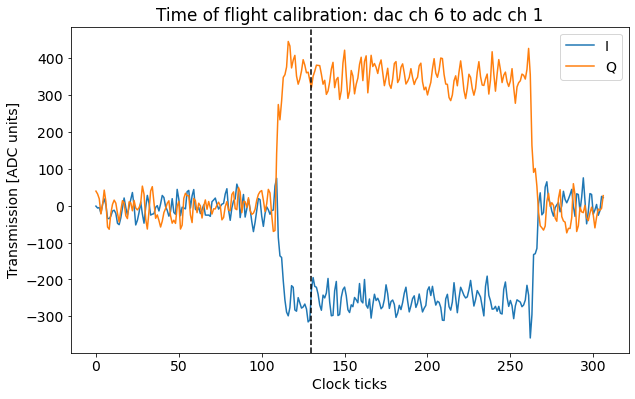

In [12]:
tof.display(adc_trig_offset=130)

# Eg-Gf calibration

In [9]:
save_data = True
saved_files = []

In [10]:
f_ge = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ge])
f_ef = np.array([f + (4000 if f < 1000 else 0) for f in yaml_cfg.device.qubit.f_ef])

yaml_cfg.f_EgGf = f_ge[1] + f_ef[1] - f_ge
print(yaml_cfg.f_EgGf)

[2018.15394645 3364.253      2683.40845344 2403.4104884 ]


In [19]:
np.reshape([[1,2],[3,4]], newshape=(2,2))

array([[1, 2],
       [3, 4]])

######### BEGINNING QUBIT 0 #########
-------- pulse probe eg-gf --------


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2016.1754674535835, HWHM 0.9674946607351219
Found peak in avgq data (qubit A) at [MHz] 2016.289698634708, HWHM 0.8962993756429749
Found peak in avgi data (qubit B) at [MHz] 2016.305249208083, HWHM 0.959853317577474
Found peak in avgq data (qubit B) at [MHz] 2016.303901276601, HWHM -1.0706380960992288


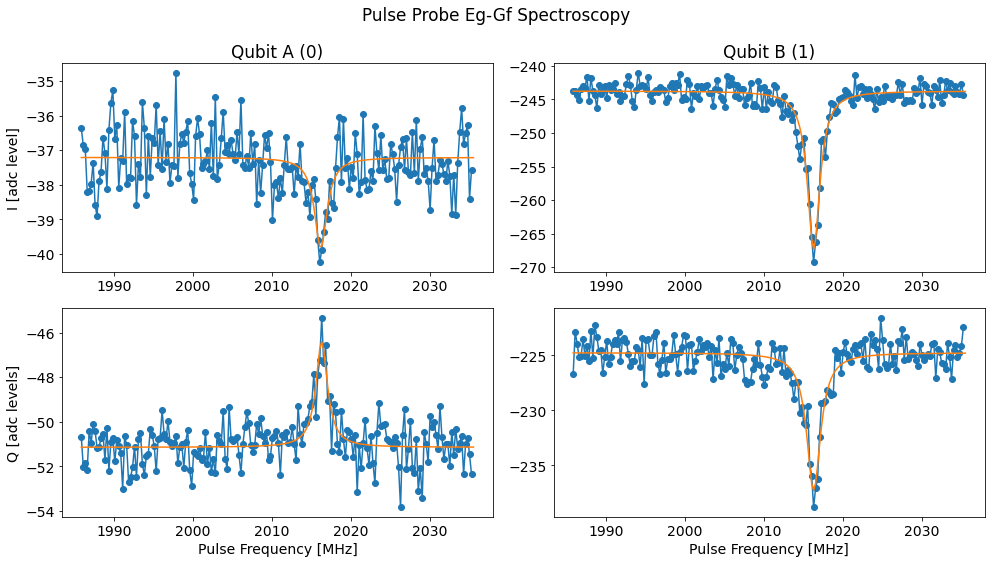

name 'qEgGfspec_fit' is not defined
!!!!!!! Eg-Gf PULSE PROBE FAILED ON QUBIT 0 !!!!!!!
######### BEGINNING QUBIT 2 #########
-------- pulse probe eg-gf --------


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2677.0615554920428, HWHM 3.4656480177242397
Found peak in avgq data (qubit A) at [MHz] 2677.6638294509, HWHM 4.684822855300061
Found peak in avgi data (qubit B) at [MHz] 2677.584031686009, HWHM 4.461208651567879
Found peak in avgq data (qubit B) at [MHz] 2677.200589142246, HWHM 4.314083603288119


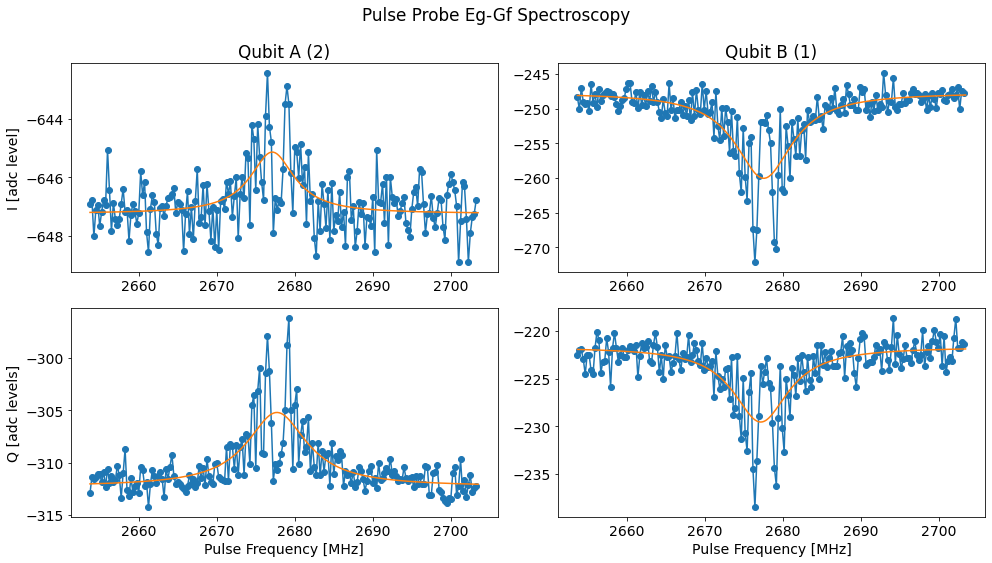

name 'qEgGfspec_fit' is not defined
!!!!!!! Eg-Gf PULSE PROBE FAILED ON QUBIT 2 !!!!!!!
######### BEGINNING QUBIT 3 #########
-------- pulse probe eg-gf --------


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in avgi data (qubit A) at [MHz] 2394.5673836842907, HWHM 1.7478985082915441
Found peak in avgq data (qubit A) at [MHz] 2394.3129513692998, HWHM 1.5889597220388485
Found peak in avgi data (qubit B) at [MHz] 2394.3921644863353, HWHM 1.6313167674034765
Found peak in avgq data (qubit B) at [MHz] 2394.491998049603, HWHM 1.6088582080053007


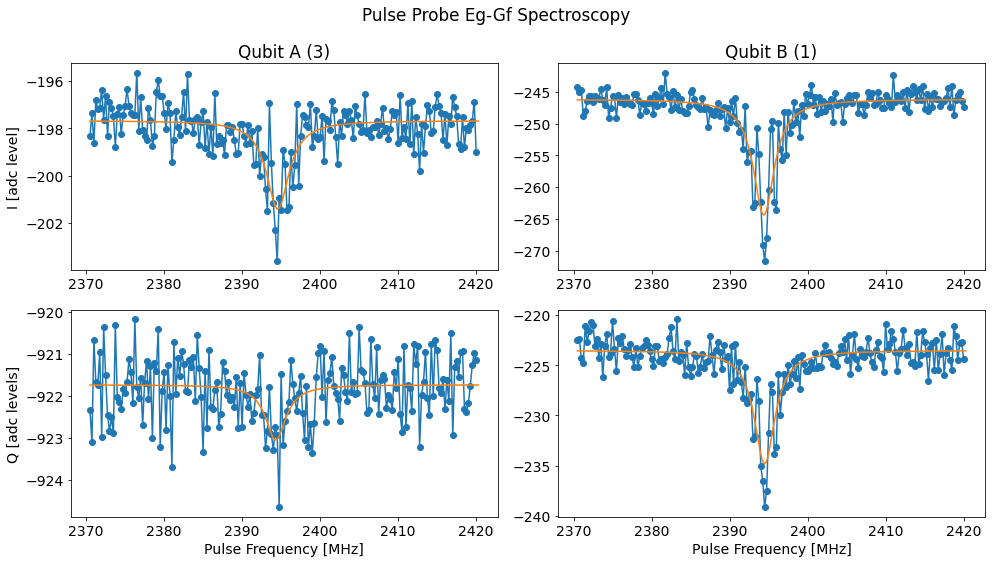

name 'qEgGfspec_fit' is not defined
!!!!!!! Eg-Gf PULSE PROBE FAILED ON QUBIT 3 !!!!!!!


In [11]:
q1 = 1
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    print(f"-------- pulse probe eg-gf --------")
    qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_EgGf_spectroscopy_qubit{q0}{q1}",
        config_file=config_path,
    )
    qEgGfspec.cfg = AttrDict(deepcopy(yaml_cfg))

    span = 50
    npts = 200

    qEgGfspec.cfg.expt = dict(
        start=qEgGfspec.cfg.device.qubit.f_EgGf[q0] - span/2, # Eg-Gf probe frequency [MHz]
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=10, # Number of start to finish sweeps to average over
        length=2, # Eg-Gf probe constant pulse length [us]
        gain=3000, # Eg-Gf const pulse gain
        qubits=[q0, q1],
    )

    try:
        qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [0]*4 # [iA, qA, iB, qB]
        best_fit_errs = [np.inf]*4
        for sign in [-1, 1]:
            try: 
                qEgGfspec.analyze(fit=True, signs=[[sign, sign], [sign, sign]])
                fit_err_iA = qEgGfspec.data['fitA_err_avgi'][2][2]
                fit_err_qA = qEgGfspec.data['fitA_err_avgq'][2][2]
                fit_err_iB = qEgGfspec.data['fitB_err_avgi'][2][2]
                fit_err_qB = qEgGfspec.data['fitB_err_avgq'][2][2]
                fit_errs = [fit_err_iA, fit_err_qA, fit_err_iB, fit_err_qB]
                for i, (fit_err, best_fit_err) in enumerate(zip(fit_errs, best_fit_errs)):
                    if fit_err < best_fit_err:
                        best_signs[i] = sign
                        best_fit_errs[i] = fit_err
            except Exception as e:
                print(e)
                continue
        best_signs = np.reshape(best_signs, (2,2))
        try:
            qEgGfspec.analyze(fit=True, signs=best_signs)
            qEgGfspec.display(fit=True, signs=best_signs)
        except Exception as e:
            print(e)
            print(f'WARNING: Fit failed for Q{q0} eg-gf, please manually fix!')
            continue

        # qEgGfspec_fit, qEgGfspec_fit_err = meas.fitting.get_best_fit(qEgGfspec.data, prefixes=('fitA', 'fitB'))

        yaml_cfg.device.qubit.f_EgGf[q0] = qEgGfspec_fit[2]
        print(f'*Set Q{q0} f_EgGf to {yaml_cfg.device.qubit.f_EgGf[q0]}*')

        if save_data: saved_files.append(qEgGfspec.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! Eg-Gf PULSE PROBE FAILED ON QUBIT {q0} !!!!!!!')
        continue



In [21]:
print(saved_files)

[]
